### Observações importantes

Nesse notebook eu fiz baseado no [estudo de previsão de irradiância solar usando Regressão por vetores de suporte](https://repositorio.ufc.br/bitstream/riufc/45060/3/2018_tcc_jlogomes.pdf). Gomes, Jan Luccas de Oliveira. Com a adição de mais features, não só umidade, chuva, vento, e temperatura, mas como também adições de dias, mês, lags de até 14.
E com isso houve uma diferença muito grande no RMSE, no modelo baseado no estudo, portanto usando somente radiação e um lag de 14, o R2 =0.9014 e RMSE=3915.40 e esse gerou um R2 = 0.9258 e RMSE=0.0849.

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_row',1000)
pd.set_option('display.max_columns',40)

In [3]:
df = pd.read_csv('Dados/data_tratado.csv',sep=';')

In [4]:
def tirando_horas_sem_radiacao(df):
    condicao_irradiacao = (df.HORA<=19) & (df.HORA>=5)
    df = df[condicao_irradiacao]
    return df
df = tirando_horas_sem_radiacao(df)
df.head()

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,DT_MEDICAO,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO,HORA,RAD
8,SAO PAULO - MIRANTE,924.2,24.8,-23.496294,924.2,SP,-3.540,17.0,23.9,-46.620088,64.0,17.1,11.0,2015-01-01,0.0,923.7,65.0,0.5,16.8,24.1,3.1,24.0,65.0,A701,800,5,0.000
9,SAO PAULO - MIRANTE,924.4,24.7,-23.496294,924.4,SP,115.361,16.9,23.8,-46.620088,62.0,17.0,344.0,2015-01-01,0.0,924.2,65.0,1.3,16.8,24.6,3.5,24.6,62.0,A701,900,6,115.361
10,SAO PAULO - MIRANTE,924.9,26.5,-23.496294,924.9,SP,732.567,17.6,24.4,-46.620088,59.0,18.3,278.0,2015-01-01,0.0,924.4,64.0,0.5,16.8,26.4,3.2,25.9,60.0,A701,1000,7,732.567
11,SAO PAULO - MIRANTE,925.5,23.7,-23.496294,925.5,SP,1597.737,16.7,25.8,-46.620088,55.0,17.9,318.0,2015-01-01,0.0,924.9,61.0,3.6,16.5,26.6,6.7,26.4,55.0,A701,1100,8,1597.737
12,SAO PAULO - MIRANTE,925.4,28.3,-23.496294,925.5,SP,2405.176,18.1,26.2,-46.620088,52.0,18.1,348.0,2015-01-01,0.0,925.4,56.0,1.6,16.5,28.4,8.9,28.4,54.0,A701,1200,9,2405.176


### Baseado no trabalho

In [5]:
# import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [6]:
# funçãoque cria a janela d previsão com N elementos

def create_lags(df,N):
    for i in range(N):
        df['Lag'+str(i+1)] = df.RAD.shift(i+1)
    return df

In [7]:
df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')
ts = df.set_index('DT_MEDICAO')

ts['day'] = ts.index.day
ts['dayofyear'] = ts.index.dayofyear
ts['weekday'] = ts.index.weekday
ts['weekofyear'] = ts.index.weekofyear

ts['month'] = ts.index.month
ts['is_month_start'] = ts.index.is_month_start
ts['is_month_end'] = ts.index.is_month_end

ts['year'] = ts.index.year
ts['is_year_start'] = ts.index.is_year_start
ts['ano_fim'] = ts.index.is_year_end

ts['quarter'] = ts.index.quarter
ts['quarter_comeco'] = ts.index.is_quarter_start
ts['quarter_fim'] = ts.index.is_quarter_end

ts = ts.dropna()

In [10]:
create_lags(ts,14)[1:20] #horas que tem medido a radiação solar/dia
ts = ts.dropna()

In [11]:
from funcoes import low_var,is_constant

In [12]:
is_constant(ts)

DC_NOME is constant.
PRE_INS OK!
TEM_SEN OK!
VL_LATITUDE is constant.
PRE_MAX OK!
UF is constant.
RAD_GLO OK!
PTO_INS OK!
TEM_MIN OK!
VL_LONGITUDE is constant.
UMD_MIN OK!
PTO_MAX OK!
VEN_DIR OK!
CHUVA OK!
PRE_MIN OK!
UMD_MAX OK!
VEN_VEL OK!
PTO_MIN OK!
TEM_MAX OK!
VEN_RAJ OK!
TEM_INS OK!
UMD_INS OK!
CD_ESTACAO is constant.
HR_MEDICAO OK!
HORA OK!
RAD OK!
day OK!
dayofyear OK!
weekday OK!
weekofyear OK!
month OK!
is_month_start OK!
is_month_end OK!
year OK!
is_year_start OK!
ano_fim OK!
quarter OK!
quarter_comeco OK!
quarter_fim OK!
Lag1 OK!
Lag2 OK!
Lag3 OK!
Lag4 OK!
Lag5 OK!
Lag6 OK!
Lag7 OK!
Lag8 OK!
Lag9 OK!
Lag10 OK!
Lag11 OK!
Lag12 OK!
Lag13 OK!
Lag14 OK!
-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-
The % of cte column is: 9.434% 
The % of not cte columns is: 90.566%


In [13]:
low_var(ts)

PRE_INS: 0.02068  OK!
TEM_SEN: 0.01832  OK!
VL_LATITUDE baixa variância: 0.00000
PRE_MAX: 0.02049  OK!
RAD_GLO: 0.09301  OK!
PTO_INS: 0.01656  OK!
TEM_MIN: 0.02072  OK!
VL_LONGITUDE baixa variância: 0.00000
UMD_MIN: 0.04441  OK!
PTO_MAX: 0.01676  OK!
VEN_DIR: 0.07209  OK!
CHUVA baixa variância: 0.00036
PRE_MIN: 0.02056  OK!
UMD_MAX: 0.04030  OK!
VEN_VEL: 0.01251  OK!
PTO_MIN: 0.01613  OK!
TEM_MAX: 0.02318  OK!
VEN_RAJ: 0.01220  OK!
TEM_INS: 0.02074  OK!
UMD_INS: 0.04419  OK!
HR_MEDICAO: 0.09524  OK!
HORA: 0.09524  OK!
RAD: 0.09327  OK!
day: 0.08600  OK!
dayofyear: 0.08340  OK!
weekday: 0.11108  OK!
weekofyear: 0.08389  OK!
month: 0.09824  OK!
is_month_start: 0.03144  OK!
is_month_end: 0.03178  OK!
year: 0.11106  OK!
is_year_start: 0.00237  OK!
ano_fim: 0.00273  OK!
quarter: 0.13862  OK!
quarter_comeco: 0.01048  OK!
quarter_fim: 0.01083  OK!
Lag1: 0.09327  OK!
Lag2: 0.09327  OK!
Lag3: 0.09327  OK!
Lag4: 0.09327  OK!
Lag5: 0.09328  OK!
Lag6: 0.09329  OK!
Lag7: 0.09329  OK!
Lag8: 0.09330 

['VL_LATITUDE', 'VL_LONGITUDE', 'CHUVA']

In [14]:
ts.columns

Index(['DC_NOME', 'PRE_INS', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'RAD_GLO', 'PTO_INS', 'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'CHUVA', 'PRE_MIN', 'UMD_MAX', 'VEN_VEL', 'PTO_MIN',
       'TEM_MAX', 'VEN_RAJ', 'TEM_INS', 'UMD_INS', 'CD_ESTACAO', 'HR_MEDICAO',
       'HORA', 'RAD', 'day', 'dayofyear', 'weekday', 'weekofyear', 'month',
       'is_month_start', 'is_month_end', 'year', 'is_year_start', 'ano_fim',
       'quarter', 'quarter_comeco', 'quarter_fim', 'Lag1', 'Lag2', 'Lag3',
       'Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9', 'Lag10', 'Lag11',
       'Lag12', 'Lag13', 'Lag14'],
      dtype='object')

In [15]:
display(ts.corr()['RAD'].sort_values(ascending=True))

UMD_INS          -0.686650
UMD_MIN          -0.637616
UMD_MAX          -0.595393
Lag8             -0.588798
Lag7             -0.584553
Lag9             -0.474134
Lag6             -0.460548
Lag10            -0.262620
Lag5             -0.237194
PTO_MIN          -0.164135
PTO_INS          -0.129114
CHUVA            -0.096882
PRE_INS          -0.069784
PRE_MIN          -0.022695
PRE_MAX          -0.016403
PTO_MAX          -0.014022
is_month_start   -0.001443
is_month_end      0.001233
weekday           0.002588
quarter_comeco    0.005114
weekofyear        0.008059
quarter_fim       0.008902
quarter           0.009267
Lag11             0.009274
month             0.010264
ano_fim           0.011152
dayofyear         0.011849
is_year_start     0.012289
day               0.012624
year              0.046772
Lag4              0.051219
HORA              0.085977
HR_MEDICAO        0.085977
VEN_RAJ           0.194127
VEN_DIR           0.208632
VEN_VEL           0.216523
Lag12             0.297532
L

In [16]:
ts_copy = ts.copy()

In [17]:
ts_escalar=ts.reset_index()[['HORA','RAD','UMD_INS','TEM_INS']]

In [18]:
cols = ['TEM_INS', 'UMD_INS','VEN_DIR', 'CHUVA','HORA','day', 'dayofyear', 'weekday', 'weekofyear', 'month',
        'is_month_start', 'is_month_end', 'year', 'is_year_start', 'ano_fim','quarter', 'quarter_comeco', 
        'quarter_fim', 'Lag1', 'Lag2', 'Lag3','Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9', 'Lag10', 'Lag11',
        'Lag12', 'Lag13', 'Lag14']
X = ts[cols]

y=ts[['RAD']]

In [19]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

min_max_scaler.fit(X)
X_scaled = min_max_scaler.transform(X)

In [22]:
X_scaled=pd.DataFrame(X_scaled,columns=cols)

In [23]:
X_scaled[0:10]

,TEM_INS,UMD_INS,VEN_DIR,CHUVA,HORA,day,dayofyear,weekday,weekofyear,month,is_month_start,is_month_end,year,is_year_start,ano_fim,quarter,quarter_comeco,quarter_fim,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12,Lag13,Lag14
0,0.638554,0.529412,0.721448,0.0,1.000000,0.000000,0.00000,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160,0.028843,0.000000
1,0.620482,0.552941,0.835655,0.0,0.000000,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160,0.028843
2,0.629518,0.541176,0.944290,0.0,0.071429,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473,0.183160
3,0.638554,0.552941,0.916435,0.0,0.142857,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352,0.399473
4,0.674699,0.505882,0.883008,0.0,0.214286,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178,0.601352
5,0.713855,0.494118,0.885794,0.0,0.285714,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563,0.707178
6,0.771084,0.423529,0.805014,0.0,0.357143,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280,0.871563
7,0.798193,0.341176,0.799443,0.0,0.428571,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753,0.894280
8,0.822289,0.341176,0.863510,0.0,0.500000,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850291,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255,0.920753
9,0.840361,0.294118,0.799443,0.0,0.571429,0.033333,0.00274,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882924,0.850291,0.518497,0.284040,0.208651,0.071267,0.012051,0.000000,0.000000,0.031281,0.431237,0.534369,0.688114,0.752255


In [24]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(y)
y_scaled = min_max_scaler.transform(y)

In [25]:
# Define e normaliza as entradas X e saídas Y e divide em 70% para treino e 30% pra teste
y = y_scaled
X = X_scaled

In [43]:
y_test

array([[0.10760369],
       [0.33283053],
       [0.67303603],
       ...,
       [0.02199638],
       [0.05442378],
       [0.        ]])

In [27]:
X.shape, y.shape

((38341, 32), (38341, 1))

In [28]:
size = int(len(ts)*.7)

X_train, y_train, X_test, y_test = X[:size], y[:size], X[size:],y[size:]

In [29]:
#Cria uma SVR, treina e prediz os valores
reg = SVR(kernel='rbf', C=1.0, epsilon=0.01)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [36]:
index = df['DT_MEDICAO'].iloc[14:]

index_train, index_test = index[:size], index[size:]

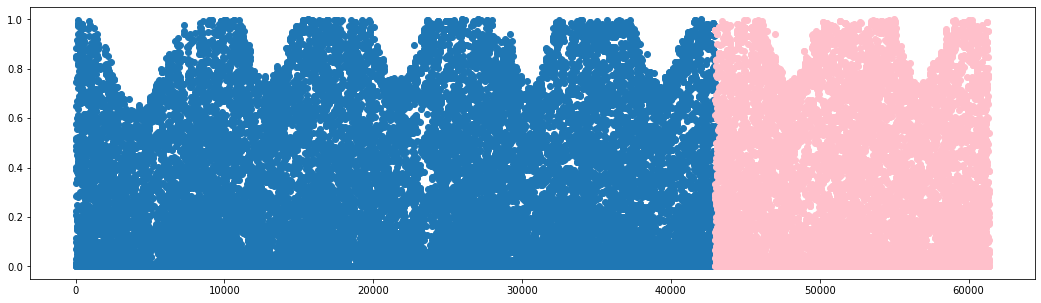

In [38]:
plt.figure(figsize=(18, 5))
plt.scatter(index_train.index, y_train)
plt.scatter(index_test.index, y_test,c='pink');

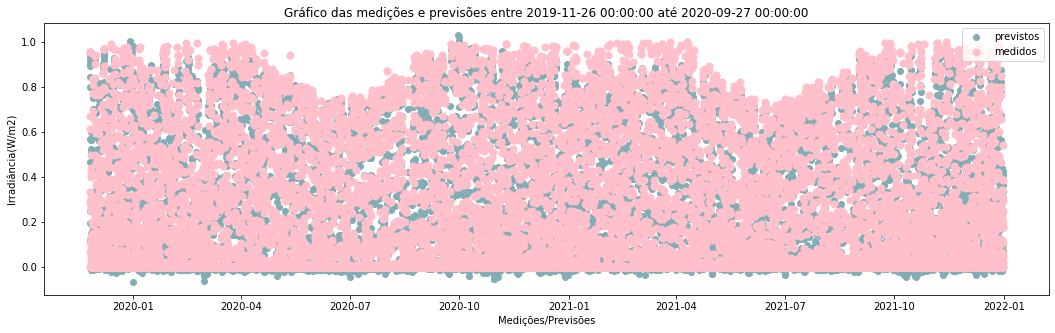

In [40]:
plt.figure(figsize=(18, 5))
plt.scatter(index_test, y_pred,c='#83adb5', label='previstos')
plt.scatter(index_test, y_test, c='pink',label='medidos',lw=2)
plt.xlabel('Medições/Previsões')
plt.ylabel('Irradiância(W/m2)')
plt.legend(loc='upper right')
plt.title(f'Gráfico das medições e previsões entre {index_test[0:4601].min()} até {index_test[0:4601].max()}');

In [75]:
(y_test.flatten()-y_pred).max()


0.5616913003607762

In [64]:
pd.DataFrame(y_test-y_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
0,11503.0,0.242956,0.311774,-0.072699,-0.055414,0.138783,0.501855,0.927301
1,11503.0,0.064558,0.311774,-0.251097,-0.233812,-0.039615,0.323457,0.748903
2,11503.0,-0.251978,0.311774,-0.567633,-0.550348,-0.356151,0.006921,0.432367
3,11503.0,-0.531168,0.311774,-0.846823,-0.829538,-0.635341,-0.272269,0.153177
4,11503.0,-0.629448,0.311774,-0.945103,-0.927817,-0.733620,-0.370549,0.054897
...,...,...,...,...,...,...,...,...
11498,11503.0,-0.023173,0.311774,-0.338828,-0.321543,-0.127346,0.235726,0.661172
11499,11503.0,0.136612,0.311774,-0.179043,-0.161758,0.032439,0.395511,0.820957
11500,11503.0,0.215363,0.311774,-0.100292,-0.083006,0.111190,0.474262,0.899708
11501,11503.0,0.207677,0.311774,-0.107979,-0.090693,0.103504,0.466575,0.892021


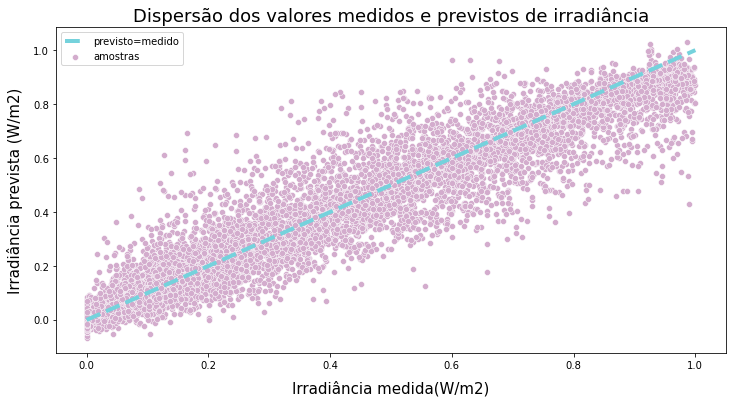

In [147]:
p = np.array([0,1])
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
plt.title('Dispersão dos valores medidos e previstos de irradiância',fontsize=18)
ax =plt.plot(p,p,color='#75d2dc',label='previsto=medido', lw=4,ls='--')
ax=sns.scatterplot(y_test.flatten(), y_pred, color='#d3accd',label='amostras')
ax.set_ylabel('Irradiância prevista (W/m2)', fontsize=15, fontweight="normal", labelpad=10)
ax.set_xlabel('Irradiância medida(W/m2)', fontsize=15, fontweight="normal", labelpad=10)
plt.legend(loc='upper left');

In [159]:
# função que  calcula o erro percentual para cada previsão, em que 
## erro =vetor de erros percentuais para cada amostra

def erro(test,pred):
    erro=np.repeat(0,len(test))
    for i in range(len(test)):
        if test[i]==0:
            erro[i]=0
        else:
            erro[i]=100*(np.abs(test[i]-pred[i]))/test[i]
    return erro

In [160]:
erro = erro(y_test,y_pred)
erro

array([ 32,  24,  15, ..., 355,  98,   0])

In [166]:
erro.mean(), erro.std()

(121.37355472485439, 1943.2055460759195)

In [167]:
pd.DataFrame(erro).describe().T

,count,mean,std,min,25%,50%,75%,max
0,11503.0,121.373555,1943.290017,0.0,2.0,12.0,35.0,134120.0


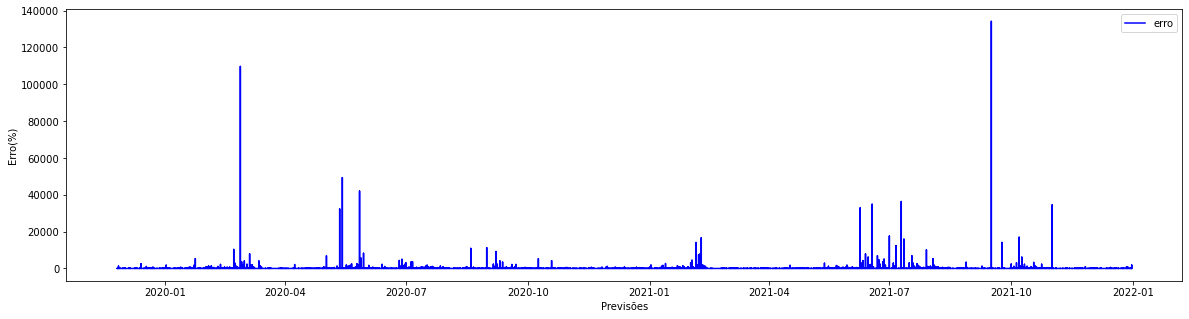

In [163]:
plt.figure(figsize=(20,5))
plt.plot(index_test, erro, color='blue', label='erro')
plt.xlabel('Previsões')
plt.ylabel('Erro(%)')
plt.legend();

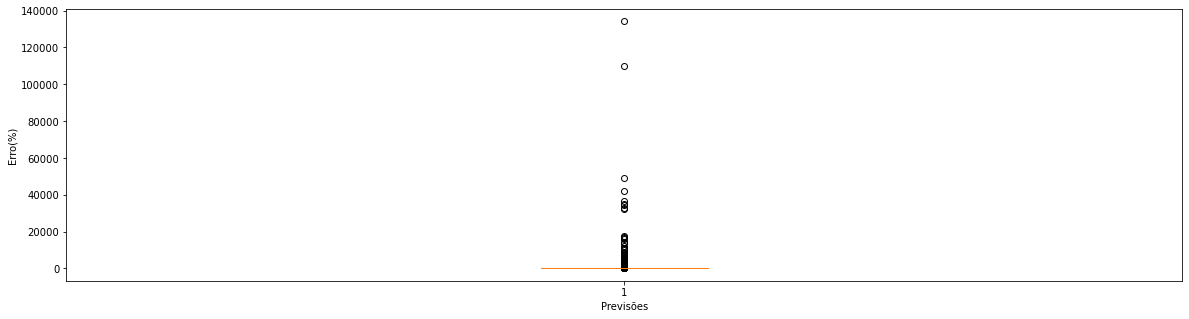

In [168]:
plt.figure(figsize=(20,5))
plt.boxplot( erro)
plt.xlabel('Previsões')
plt.ylabel('Erro(%)');

In [128]:
erro[9899] ,index_test.iloc[9899]

(134120, Timestamp('2021-09-16 00:00:00'))

In [131]:
y_test[9899],y_pred[9899]

(array([1.05010186e-05]), 0.01409451238046644)

In [171]:
pd.DataFrame(y_test-y_pred, index = index_test).plot();

ValueError: Image size of 380x172567 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [169]:
#função que calcula os erros menos ou iguais a n % em que
## err= vetor de erros percentuais

def percent_erro(erro,n):
    cont=0
    for i in range(len(erro)):
        if erro[i]<=n:
            cont=cont+1
    return 100*cont/(len(erro))       

In [170]:
# função que calcula os erros menores que %n entre período de horas
## em que :  hor=vetor de horas
##           h_ini = hora inicial
##           h_fin = hora final

def percent_erro_hora(erro=erro, hor = df['HORA'], h_ini=None,h_fin=None,n=None):
    cont_erro = 0
    cont_hora = 0
    for i in range(len(erro)):
        if hor.iloc[i]>=h_ini and df['HORA'].iloc[i]<h_fin:
            cont_hora = cont_hora+1
            if err[i]<=n:
                cont_erro=cont_erro+1
                
    return 100*cont_erro/cont_hora


In [91]:
percent_erro(erro,23) # mais de 65% dos erros são menores ou igual a 23

65.10475528123098

In [164]:
# Cálculo do erro médio quadrático 

rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.08491442760376633

In [165]:
# Cálculo do coeficiente de determinação R2
r2_score(y_test,y_pred)

0.9258141001074107

In [106]:
# função para cálculo do erro médio quadrático normalizado, em que:
## test = dados medidos do período de teste
## pred = dados previstos para o período de teste

def n_rmse(test, pred):
    erro=np.repeat(0, len(test))
    media = (sum(test)/len(test))
    soma = 0
    for i in range(len(test)):
        erro[i]=((pred[i]-test[i])/(media))**2
        soma=soma+erro[i]
    return 100*(soma/(len(test)))**(1/2)


In [107]:
n_rmse(y_test,y_pred)

9.50848027179017

In [72]:
# Método da persistência 

w=df.iloc[:,1].values
w_train, w_test = w[:train_idx],w[train_idx:]

In [42]:
y_test.shape, w_test.shape

((11503,), (11517,))

In [ ]:
rmse = sqrt(mean_squared_error(y_test, w_test))
rmse

In [ ]:
r2_score(y_test,w_test)
n_rmse(y_test,w_test)